In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

In [ ]:
df = pd.read_csv("/content/train_E6oV3lV.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# Display the column names
print("Column names:", df.columns)

# Alternatively, display the first few rows to inspect the data
print("First few rows:\n", df.head())


Column names: Index(['id', 'tweet'], dtype='object')
First few rows:
       id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


In [ ]:
hate_tweet = df[df.label ==  1]
hate_tweet.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [ ]:
normal_tweet = df[df.label == 0]
normal_tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


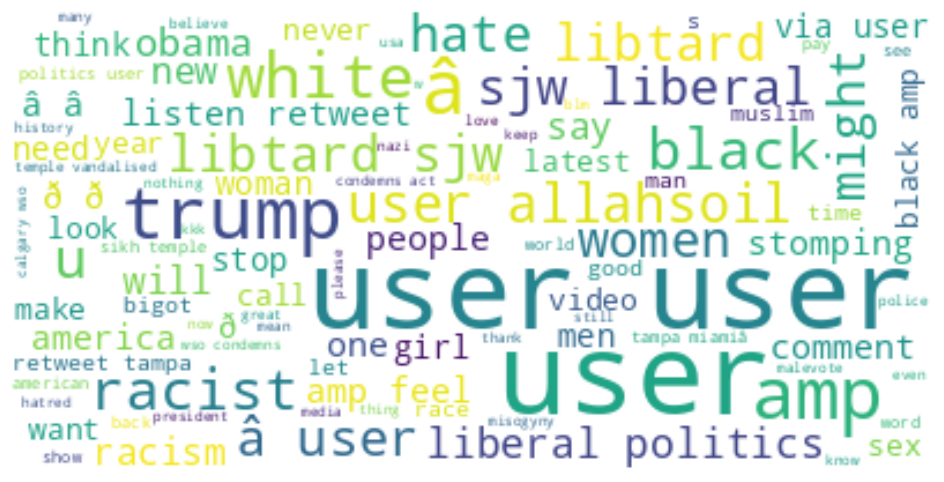

In [ ]:
# Hate Word clouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in hate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#distributions
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0,29720,92.98542
1,1,2242,7.01458


In [ ]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [ ]:
df['processed_tweets'] = df['tweet'].apply(process_tweet)
df.head()

,id,label,tweet,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [ ]:
#As this dataset is highly imbalance we have to balance this by over sampling
cnt_non_fraud = df[df['label'] == 0]['processed_tweets'].count()
df_class_fraud = df[df['label'] == 1]
df_class_nonfraud = df[df['label'] == 0]
df_class_fraud_oversample = df_class_fraud.sample(cnt_non_fraud, replace=True)
df_oversampled = pd.concat([df_class_nonfraud, df_class_fraud_oversample], axis=0)

print('Random over-sampling:')
print(df_oversampled['label'].value_counts())

Random over-sampling:
0    29720
1    29720
Name: label, dtype: int64


In [23]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [25]:
x_train_counts = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [26]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(47552, 34180)
(47552, 34180)


In [27]:
x_test_counts = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [31]:
model = RandomForestClassifier(n_estimators=100)  # Adjust the number as needed

In [32]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1)  # Use all available cores


In [33]:
model = RandomForestClassifier(n_estimators=500, max_depth=10)  # Adjust the depth as needed


In [34]:
model.fit(x_train_tfidf[:1000], y_train[:1000])  # Adjust the subset size as needed


RandomForestClassifier(max_depth=10, n_estimators=500)

In [35]:
predictions = model.predict(x_test_tfidf)

In [36]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[5130  779]
 [1367 4612]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5909
           1       0.86      0.77      0.81      5979

    accuracy                           0.82     11888
   macro avg       0.82      0.82      0.82     11888
weighted avg       0.82      0.82      0.82     11888



In [37]:
#Building XGBoost Model
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_tfidf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=22, ...)

In [38]:
predict_xgb = model_bow.predict(x_test_tfidf)

In [39]:
print(confusion_matrix(y_test,predict_xgb))
print(classification_report(y_test,predict_xgb))

[[5552  357]
 [ 116 5863]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5909
           1       0.94      0.98      0.96      5979

    accuracy                           0.96     11888
   macro avg       0.96      0.96      0.96     11888
weighted avg       0.96      0.96      0.96     11888



In [40]:
#SVM Model
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)

LinearSVC()

In [41]:
predict_svm = lin_clf.predict(x_test_tfidf)

In [42]:
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[5749  160]
 [  10 5969]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5909
           1       0.97      1.00      0.99      5979

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [43]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [44]:
logreg = LogisticRegression(random_state=42)

In [45]:
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

LogisticRegression(random_state=42)

In [46]:
predict_log = logreg.predict(x_test_tfidf)

In [47]:
print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[5670  239]
 [  50 5929]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5909
           1       0.96      0.99      0.98      5979

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [48]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train_tfidf, y_train)

MultinomialNB()

In [49]:
predict_nb = NB.predict(x_test_tfidf)

In [50]:
print(confusion_matrix(y_test,predict_nb))
print(classification_report(y_test, predict_nb))

[[5428  481]
 [  76 5903]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      5909
           1       0.92      0.99      0.95      5979

    accuracy                           0.95     11888
   macro avg       0.96      0.95      0.95     11888
weighted avg       0.96      0.95      0.95     11888



In [51]:
#Test Data Set
df_test = pd.read_csv("/content/test_tweets_anuFYb8.csv")
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [52]:
df_test.shape

(17197, 2)

In [53]:
df_test['processed_tweets'] = df_test['tweet'].apply(process_tweet)
df_test.head()

,id,tweet,processed_tweets
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...


In [54]:
X = df_test['processed_tweets']
x_test_counts = count_vect.transform(X)
x_test_tfidf = transformer.transform(x_test_counts)

In [55]:
df_test['predict_nb'] = NB.predict(x_test_tfidf)
df_test[df_test['predict_nb']==1]

,id,tweet,processed_tweets,predict_nb
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality on right wing f...,1
26,31989,chick gets fucked hottest naked lady,chick gets fucked hottest naked lady,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo the taiji fisherman no bullying no racis...,1
34,31997,i say we because i'm speaking collectively. i'...,i say we because i m speaking collectively i v...,1
35,31998,wish we could talk,wish we could talk,1
...,...,...,...,...
17163,49126,@user @user i'd be ashamed of my state if i to...,i d be ashamed of my state if i took any respo...,1
17176,49139,@user @user are the most racist pay ever!!!!!,are the most racist pay ever,1
17188,49151,"black professor demonizes, proposes nazi style...",black professor demonizes proposes nazi style ...,1
17192,49155,thought factory: left-right polarisation! #tru...,thought factory left right polarisation trump ...,1


In [56]:
df_test['predict_svm'] = NB.predict(x_test_tfidf)
df_test['predict_rf'] = model.predict(x_test_tfidf)
df_test.head()

,id,tweet,processed_tweets,predict_nb,predict_svm,predict_rf
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,0,0,0
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,0,0,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...,0,0,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0,0,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...,0,0,0


In [57]:
file_name = 'test_predictions_Twitter Hate Analysis.csv'
df_test.to_csv(file_name,index=False)

# **Results**

#Algorithms                                  F1-Score

#SVM                                            99%

#Random Forest                                  98%

#XG Boost                                       91%

#Navie Bayes                                    95%

#Logistic Regression                            98%